## Use a Pipeline Construct to Chain PCA and Logistic Regression
The PCA performs unsupervised dimensionality reduction, while the logistic regression does the prediction. Also, a GridSearchCV is used to optimize the dimensionality of the PCA.

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

if sklearn.__version__ >= '0.18.0':  # Starting with sklearn version 18.0
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
else:
    from sklearn.cross_validation import train_test_split, cross_val_score
    from sklearn.cross_validation import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Load the Data

In [2]:
# Locate the Data File to be Ingested. 
data_dir = os.path.join(os.getcwd(), 'Data')
source_file = os.path.join(data_dir, 'WA-Telco-Customer-Churn-ML.xlsx')

# Read the Data from the Source File
df = pd.read_excel(source_file)

# Display the Execution Mode and the Dimensions of the DataSet Being Used.
print("DataSet Dimensions:", df.shape)

DataSet Dimensions: (7043, 21)


#### Make Appropriate Data Type Assignments

In [3]:
df.gender = df.gender.astype('category')
df.SeniorCitizen = df.SeniorCitizen.astype('category')
df.Partner = df.Partner.astype('category')
df.Dependents = df.Dependents.astype('category')
df.tenure = pd.to_numeric(df.tenure, downcast='integer', errors='coerce')
df.PhoneService = df.PhoneService.astype('category')
df.MultipleLines = df.MultipleLines.astype('category')
df.InternetService = df.InternetService.astype('category')
df.OnlineSecurity = df.OnlineSecurity.astype('category')
df.OnlineBackup = df.OnlineBackup.astype('category')
df.DeviceProtection = df.DeviceProtection.astype('category')
df.TechSupport = df.TechSupport.astype('category')
df.StreamingTV = df.StreamingTV.astype('category')
df.StreamingMovies = df.StreamingMovies.astype('category')
df.Contract = df.Contract.astype('category')
df.PaperlessBilling = df.PaperlessBilling.astype('category')
df.PaymentMethod = df.PaymentMethod.astype('category')
df.MonthlyCharges = pd.to_numeric(df.MonthlyCharges, downcast='float', errors='coerce')
df.TotalCharges = pd.to_numeric(df.TotalCharges, downcast='float', errors='coerce')
df.Churn = df.Churn.astype('category')
df.dtypes

customerID            object
gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                  int8
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float32
TotalCharges         float32
Churn               category
dtype: object

#### Separate the Predictors from the Response

In [4]:
# Separate the Dependant Variable (Target, Response, Label) from the Independant Variables (Predictor).
X = df.drop(labels=['customerID', 'Churn'], axis=1)
y = df.Churn

#### Create Training and Testing Data Sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Use 60% of the observations for training...
print('-------------------------------------------------------------------')
print("Training Observations:", X_train.shape)

# ...And use the rest for testing.
print("Testing Observations:", X_test.shape)
print('-------------------------------------------------------------------\n')

# Examine the distribution of Labels for the two datasets.
print("Training Label Distribution:\n", y_train.value_counts())
print('-------------------------------------------------------------------')
print("Testing Label Distribution:\n", y_test.value_counts())
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
Training Observations: (4225, 19)
Testing Observations: (2818, 19)
-------------------------------------------------------------------

Training Label Distribution:
 0    3105
1    1120
Name: Churn, dtype: int64
-------------------------------------------------------------------
Testing Label Distribution:
 0    2069
1     749
Name: Churn, dtype: int64
-------------------------------------------------------------------


#### Perform Scalar Normalization of Each Data Set

In [6]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Define the Pipeline
Search for the best combination of PCA truncation and classifier regularization.

In [7]:
logistic = SGDClassifier(loss='log', penalty='l2', random_state=0) #early_stopping=True, max_iter=1000, tol=1e-5) 
                         
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

#### Configure the GridSearchCV to Tune PCA Hyperparameters

In [8]:
%%time

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [6, 8, 10, 12, 14, 16, 18, 19],
    'logistic__alpha': np.logspace(-4, 4, 5),
}

grid = GridSearchCV(pipe, param_grid, iid=False, cv=5, return_train_score=False)

grid.fit(X_train, y_train)

print('-------------------------------------------------------------------')
print("Best Cross-Validation Score: %0.3f:" % grid.best_score_)
print('-------------------------------------------------------------------')
print("Bests Parameters:", grid.best_params_)
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
Best Cross-Validation Score: 0.791:
-------------------------------------------------------------------
Bests Parameters: {'logistic__alpha': 0.01, 'pca__n_components': 18}
-------------------------------------------------------------------
Wall time: 3.14 s


#### Plot the PCA Spectrum

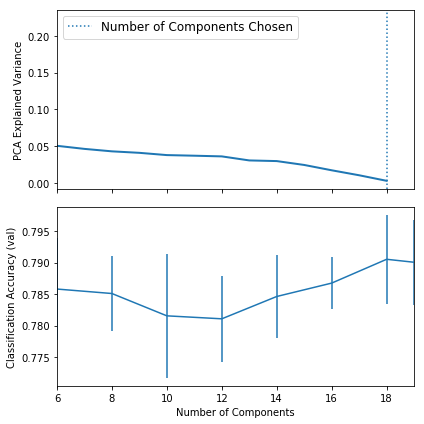

Wall time: 487 ms


In [9]:
%%time

pca.fit(X_train)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA Explained Variance')

ax0.axvline(grid.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='Number of Components Chosen')
ax0.legend(prop=dict(size=12))

# Find the Best Classifier Results for Each Number of Components
results = pd.DataFrame(grid.cv_results_)
components_col = 'param_pca__n_components'

best_clfs = results.groupby(components_col).apply(lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=False, ax=ax1)
ax1.set_ylabel('Classification Accuracy (val)')
ax1.set_xlabel('Number of Components')

plt.tight_layout()
plt.show()